In [1]:
import sys
sys.path.append("../")
import dougnet as dn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#a*(x - b)^2 + c
#x = 9
#a = 3
#b = 5
#c = 7

#3*(9 - 5)**2 + 7

# Create a new graph
g1 = dn.ComputationGraph()
g1.as_default()

# Create variables
a = dn.ParameterNode(3)                        
b = dn.ParameterNode(5)
c = dn.ParameterNode(7)

# Create placeholder
x = dn.InputNode()

# Create hidden node y
z1 = dn.subtract(x, b)

# Create hidden node y
z2 = dn.sqr(z1)

z3 = dn.mult(a, z2)

#
o = dn.add(z3, c)

In [3]:
from dougnet.graph import ForwardIterative, ForwardDFS, TopologicalSort

#topologically sort graph for iterative implementation of forward
topo_sorted_operations = []
TopologicalSort(o, topo_sorted_operations, set())



x.output = 9
print(f'Iterative forward computation: {ForwardIterative(o, topo_sorted_operations)}')
print(f'Recursive forward computation: {ForwardDFS(o, set())}')

Iterative forward computation: 55
Recursive forward computation: 55


In [4]:
#P_Yeq1_giv_x = s(W^T*x + b)


# Create a new graph
g2 = dn.ComputationGraph()
g2.as_default()

# Create paramter nodes
w_T = dn.ParameterNode(np.array([.5, .7, .1]))
b = dn.ParameterNode(2.)

# Create placeholder
X = dn.InputNode()

#
P_Yeq1_giv_x = dn.sigmoid(dn.add(dn.matmult(w_T, X), b))

In [5]:
X.output = np.array([[1, 2, -5], 
                     [3, 4, -2], 
                     [5, 6, -3]])

#topologically sort graph for iterative implementation of forward
topo_sorted_operations = []
TopologicalSort(P_Yeq1_giv_x, topo_sorted_operations, set())

print(f'Iterative forward computation: {ForwardIterative(P_Yeq1_giv_x, topo_sorted_operations)}')
print(f'Recursive forward computation: {ForwardDFS(P_Yeq1_giv_x, set())}')

Iterative forward computation: [0.9939402  0.9983412  0.09975049]
Recursive forward computation: [0.9939402  0.9983412  0.09975049]


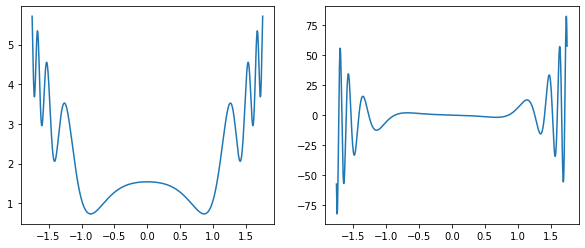

In [6]:
#f(x) = sqrt(x^2 + exp(x^2)) + cos(x^2 + exp(x^2))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,4))


x = np.linspace(-1.75, 1.75, 1000)
y = np.sqrt(x**2 + np.exp(x**2)) + np.cos(x**2 + np.exp(x**2))
y_prime = x * (1./np.sqrt( x**2 + np.exp(x**2) ) - 2 * np.sin(x**2 + np.exp(x**2)) ) * (1. + np.exp(x ** 2))

ax1.plot(x, y)
ax2.plot(x, y_prime);

In [7]:


#Create a new graph
g3 = dn.ComputationGraph()
g3.as_default()

x = dn.ParameterNode()
xsqr = dn.sqr(x)
e_xsqr = dn.exp(xsqr)
xsqr_p_e_xsqr = dn.add(xsqr, e_xsqr)
o = dn.add(dn.sqrt(xsqr_p_e_xsqr), dn.cos(xsqr_p_e_xsqr))

In [8]:
from dougnet.graph import GradDPIterative, GradDPRecursive

#f(x) = sqrt(x^2 + exp(x^2)) + cos(x^2 + exp(x^2))

#topologically sort graph for iterative implementation of forward
topo_sorted_operations = []
TopologicalSort(o, topo_sorted_operations, set())


def Deriv(output_node, parameter_node, val, graph, iterative=True):
    parameter_node.output = val
    if iterative:
        ForwardIterative(o, topo_sorted_operations)
        grads_ = GradDPIterative(o, topo_sorted_operations)
    else:
        ForwardDFS(o, set()) 
        grads_ = GradDPRecursive(o, graph.parameters)
    
    return grads_[parameter_node]

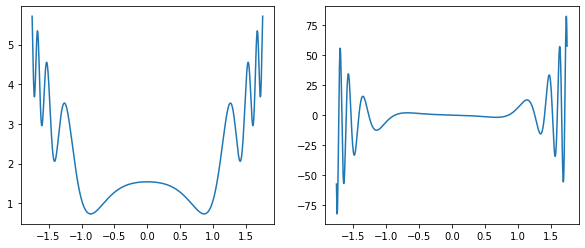

In [9]:
#compute derivative
x_arr = np.linspace(-1.75, 1.75, 1000)
dx_TD = [Deriv(o, x, val, g3, iterative=True) for val in x_arr]


#compute function
x.output = x_arr.reshape(1000, 1)
y = ForwardIterative(o, topo_sorted_operations)


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(x_arr, y)
ax2.plot(x_arr, dx_TD);

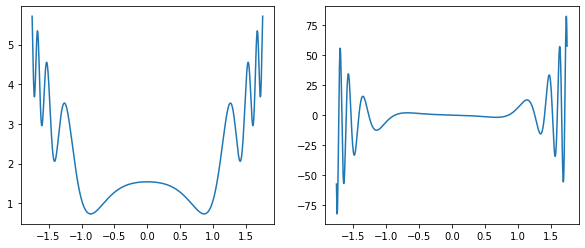

In [10]:

#compute derivative
dx_BU = [Deriv(o, x, val, g3, iterative=False) for val in x_arr]

#compute function
x.output = x_arr.reshape(1000, 1)
y = ForwardDFS(o, set()) 

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(x_arr, y)
ax2.plot(x_arr, dx_BU);

In [11]:
def PrepareData(X, y, n_classes):
    # one hot encode Ys
    Y_ohe = np.zeros((y.size, n_classes))
    Y_ohe[np.arange(y.size),y] = 1

    #transpose data 
    X = X.T
    Y_ohe = Y_ohe.T

    ## randomly shuffle columns (examples)
    random_perm_of_cols = np.random.RandomState(seed=42).permutation(X.shape[1])
    X = X[:, random_perm_of_cols]
    Y_ohe = Y_ohe[:, random_perm_of_cols]
    
    return X, Y_ohe

In [12]:
from dougnet.data.LoadData import LoadMNIST

X_train, Y_train, X_val, Y_val = LoadMNIST()

X_train, Y_train = PrepareData(X_train, Y_train, 10)
X_val, Y_val = PrepareData(X_val, Y_val, 10)

In [13]:
from dougnet.Activations import SoftMax
from dougnet.Scores import Accuracy

NNclf_rec = dn.ComputationGraph()
NNclf_rec.as_default()


#instantiate data nodes
X = dn.InputNode()
Y = dn.InputNode()

#first hidden layer
W1 = dn.WeightNode(40, 28*28)
b1 = dn.BiasNode(40)
A1 = dn.relu(dn.add(dn.matmult(W1, X), b1))

#second hidden layer
W2 = dn.WeightNode(20, 40)
b2 = dn.BiasNode(20)
A2 = dn.tanh(dn.add(dn.matmult(W2, A1), b2))

#output layer and loss node
W3 = dn.WeightNode(10, 20)
b3 = dn.BiasNode(10)
Z = dn.add(dn.matmult(W3, A2), b3)
L = dn.softmax_crossentropy_loss(Z, Y, dn.l2_reg_loss([W1, W2, W3]))


NNclf_rec.fit(X_train, Y_train, X_val, Y_val, 
              X, Y, L, Z, 
              SoftMax, 
              iterative=False,
              B=100,
              eta=.05,
              n_epochs=100,
              seed=1984, 
              progress_metric=Accuracy);

100/100 | Train/Val. Loss: 4471.21/993.72 | Train/Val. Score: 98.26%/97.14% | Elapsed Time: 96.00 secondssss

In [14]:
NNclf_iter = dn.ComputationGraph()
NNclf_iter.as_default()


#instantiate data nodes
X = dn.InputNode()
Y = dn.InputNode()

#first hidden layer
W1 = dn.WeightNode(40, 28*28)
b1 = dn.BiasNode(40)
A1 = dn.relu(dn.add(dn.matmult(W1, X), b1))

#second hidden layer
W2 = dn.WeightNode(20, 40)
b2 = dn.BiasNode(20)
A2 = dn.tanh(dn.add(dn.matmult(W2, A1), b2))

#output layer and loss node
W3 = dn.WeightNode(10, 20)
b3 = dn.BiasNode(10)
Z = dn.add(dn.matmult(W3, A2), b3)
L = dn.softmax_crossentropy_loss(Z, Y, dn.l2_reg_loss([W1, W2, W3]))

NNclf_iter.fit(X_train, Y_train, X_val, Y_val, 
               X, Y, L, Z, SoftMax, 
               iterative=True,
               B=100,
               eta=.05,
               n_epochs=100,
               seed=1984, 
               progress_metric=Accuracy);

100/100 | Train/Val. Loss: 4471.21/993.72 | Train/Val. Score: 98.26%/97.14% | Elapsed Time: 85.33 secondssss

In [15]:
# create noisy sine data

f = lambda x: np.sin(x)
low, high = -10, 10

np.random.seed(2021)
X_train = np.random.uniform(low, high, 1000).reshape(1, 1000)
Y_train = f(X_train) + np.random.normal(0, .1, 1000).reshape(1, 1000)

X_val = np.random.uniform(low, high, 100).reshape(1, 100)
Y_val = f(X_val) + np.random.normal(0, .1, 100).reshape(1, 100)

In [16]:
from dougnet.Activations import Identity
from dougnet.Scores import R2

NNreg = dn.ComputationGraph()
NNreg.as_default()


#instantiate data nodes
X = dn.InputNode()
Y = dn.InputNode()

#first hidden layer
W1 = dn.WeightNode(100, 1)
b1 = dn.BiasNode(100)
A1 = dn.tanh(dn.add(dn.matmult(W1, X), b1))

#second hidden layer
W2 = dn.WeightNode(100, 100)
b2 = dn.BiasNode(100)
A2 = dn.tanh(dn.add(dn.matmult(W2, A1), b2))

#output layer and loss node
W3 = dn.WeightNode(1, 100)
b3 = dn.BiasNode(1)
Z = dn.add(dn.matmult(W3, A2), b3)
L = dn.l2_loss(Z, Y, dn.l2_reg_loss([W1, W2, W3]))


NNreg.fit(X_train, Y_train, X_val, Y_val, 
          X, Y, L, Z, Identity, 
          iterative=True, 
          B=100,
          eta=.0005,
          n_epochs=200,
          seed=1984, 
          progress_metric=R2);

200/200 | Train/Val. Loss: 1017.05/1017.06 | Train/Val. Score: 76.63%/68.52% | Elapsed Time: 4.62 secondsss